# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 


In [81]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle


## Plots setup


In [82]:

def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()



## Load dataset


In [83]:
df = pd.read_csv("X_test_STRATUM_y_test.csv")
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_for_Mergesort_single = df
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF


# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)




# Mergesort Ranker


In [84]:
# ENKELT HERUNDER

df_sort = df_for_Mergesort_single.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort")


# MERGESORT HERUNDER PÅ BIG 
X_test_y_test_FULL = pd.DataFrame()
for i in range(200):
    dfs_test_use[i]= dfs_test_use[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use[i]= dfs_test_use[i].reset_index()
    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use[i])


X_test_y_test_FULL.index.names = ['INDEXES']


X_test_y_test_FULL_std = X_test_y_test_FULL.groupby('INDEXES').std()
X_test_y_test_FULL_mean=  X_test_y_test_FULL.groupby('INDEXES').mean()

X_test_y_test_FULL_mean["incr_col_mean"] = X_test_y_test_FULL_mean['18'].expanding().mean()
df_sort_BIG =X_test_y_test_FULL_mean

## Mergesort utility


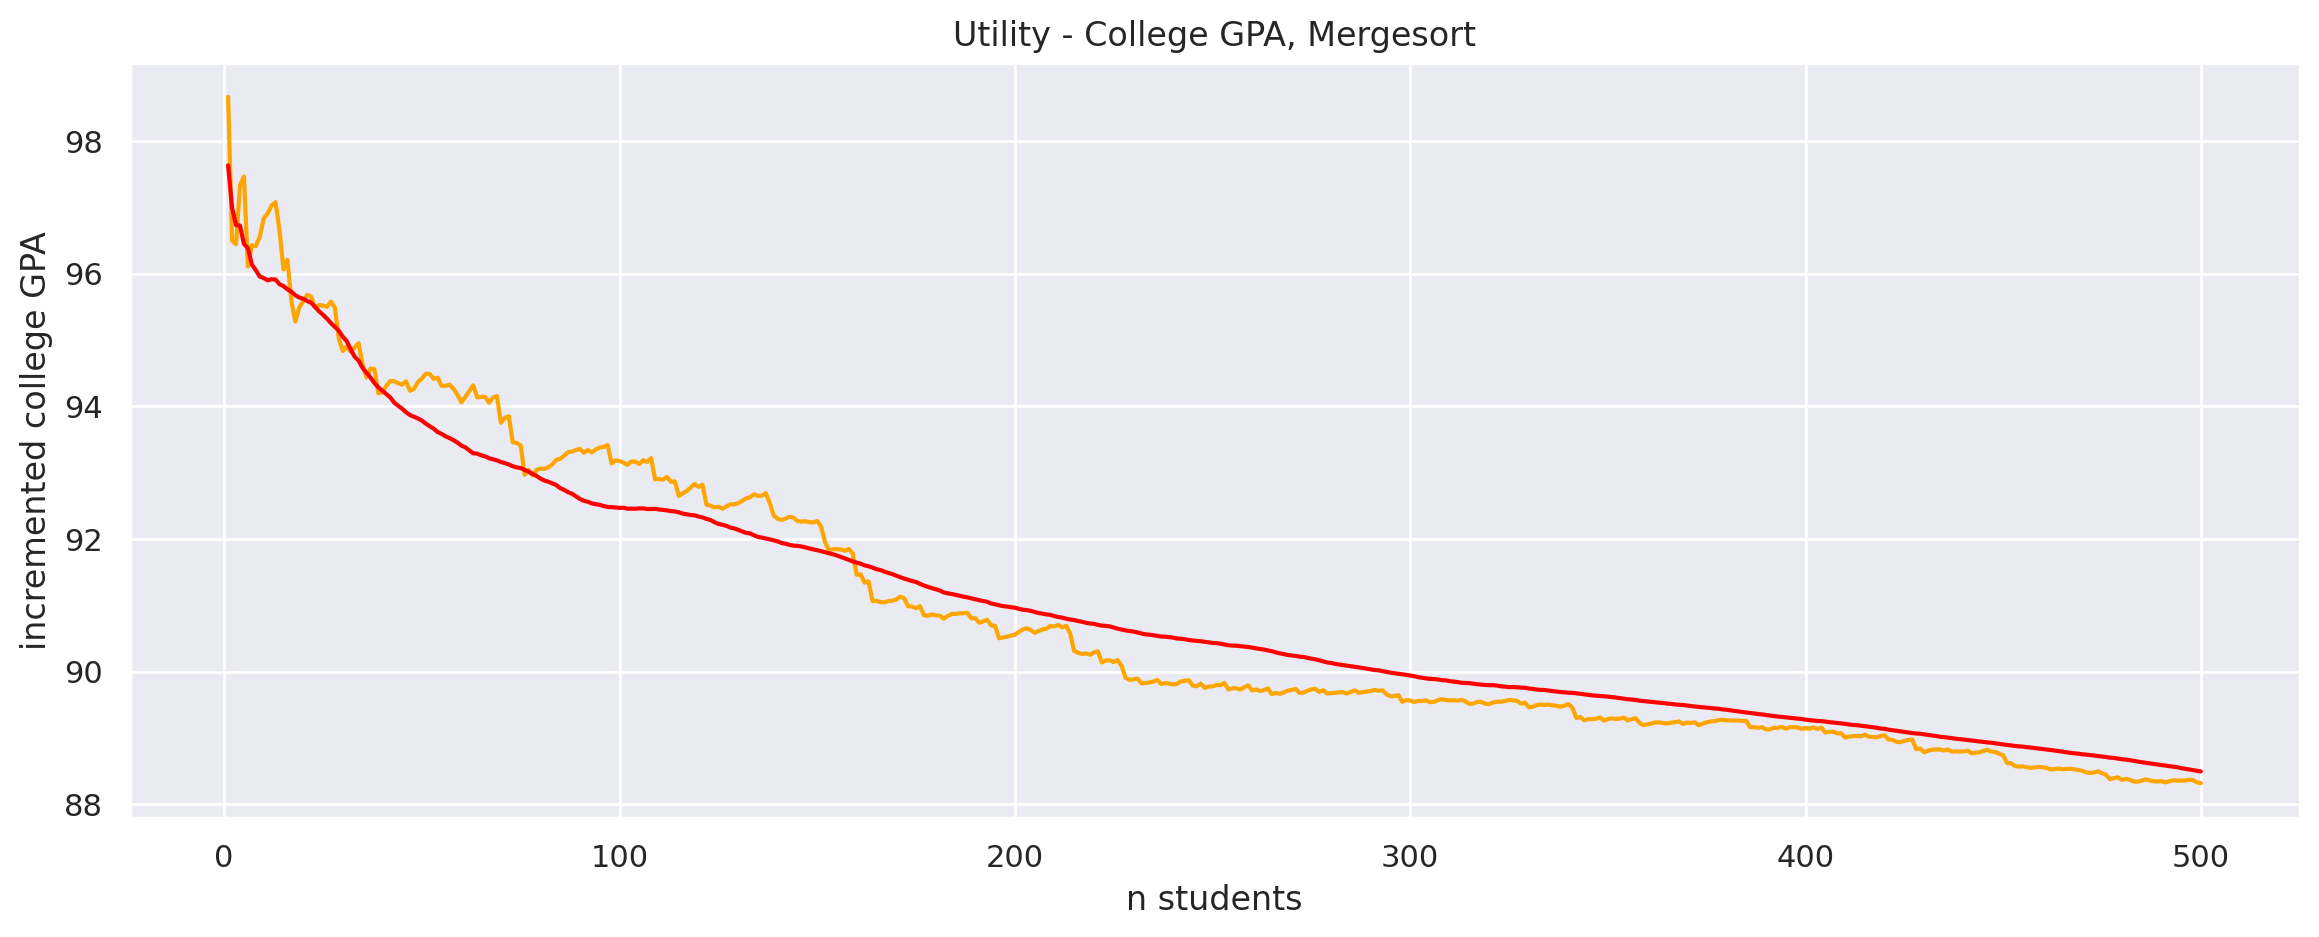

In [85]:
df_avg = df_sort.copy()
df_avg["incr_col_mean"] = df_avg.COL_GRADE_AVG.expanding().mean()
df_avg["n_students"] = range(1,len(df_avg)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_avg[:500], color="orange").set_title("Utility - College GPA, Mergesort")

df_sort_BIG["n_students"] = range(1,len(df_sort_BIG)+1)
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[:500], color="red").set_title("Utility - College GPA, Mergesort")

plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()


## Gendersort Ranker 
Choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking).

Merge sort for Female df and Male df and append and sort


In [86]:
#Gendersort all
def gender_mergesort_all(df):
    df_temp = df.copy()
    df_M = df_temp[df_temp.GENDER_bin == 0]
    df_F = df_temp[df_temp.GENDER_bin == 1]
    
    df_sort_M = df_M.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()
    df_sort_F = df_F.sort_values(by="HI_GRADE_AVG", ascending=False, kind="mergesort").reset_index()

    if df_F.HI_GRADE_AVG.max() > df_M.HI_GRADE_AVG.max():
        sorted_with_gender = pd.concat([df_sort_F,df_sort_M], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([df_sort_M,df_sort_F], sort=False).sort_index()
    
    return sorted_with_gender.reset_index()
        

gender_df = gender_mergesort_all(df_for_Mergesort_single)


In [87]:
#Gendersort all
def gender_mergesort_BIG(df):
    df = dfs_test_use
    X_test_y_test_FULL = pd.DataFrame()
    for i in range(200):
        dfs_test_use[i]= dfs_test_use[i].sort_values(by="3", ascending=False, kind="mergesort")
        dfs_test_use[i]= dfs_test_use[i].reset_index()
        X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use[i])


    X_test_y_test_FULL.index.names = ['INDEXES']
    
    X_test_y_test_FULL = X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    X_test_y_test_FULL_females = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 0]
    X_test_y_test_FULL_males = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 1]

    X_test_y_test_FULL_females = X_test_y_test_FULL_females.groupby('INDEXES').mean()

    X_test_y_test_FULL_males = X_test_y_test_FULL_males.groupby('INDEXES').mean()
  
    if X_test_y_test_FULL_females.HI_GRADE_AVG.max() > X_test_y_test_FULL_males.HI_GRADE_AVG.max():
        sorted_with_gender = pd.concat([X_test_y_test_FULL_females,X_test_y_test_FULL_males], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([X_test_y_test_FULL_males,X_test_y_test_FULL_females], sort=False).sort_index()

    return sorted_with_gender.reset_index()
  

gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


In [90]:
gender_df_BIG["incr_col_mean"] = gender_df_BIG.COL_GRADE_AVG.expanding().mean()
gender_df_BIG["n_students"] = range(1,len(gender_df_BIG)+1)

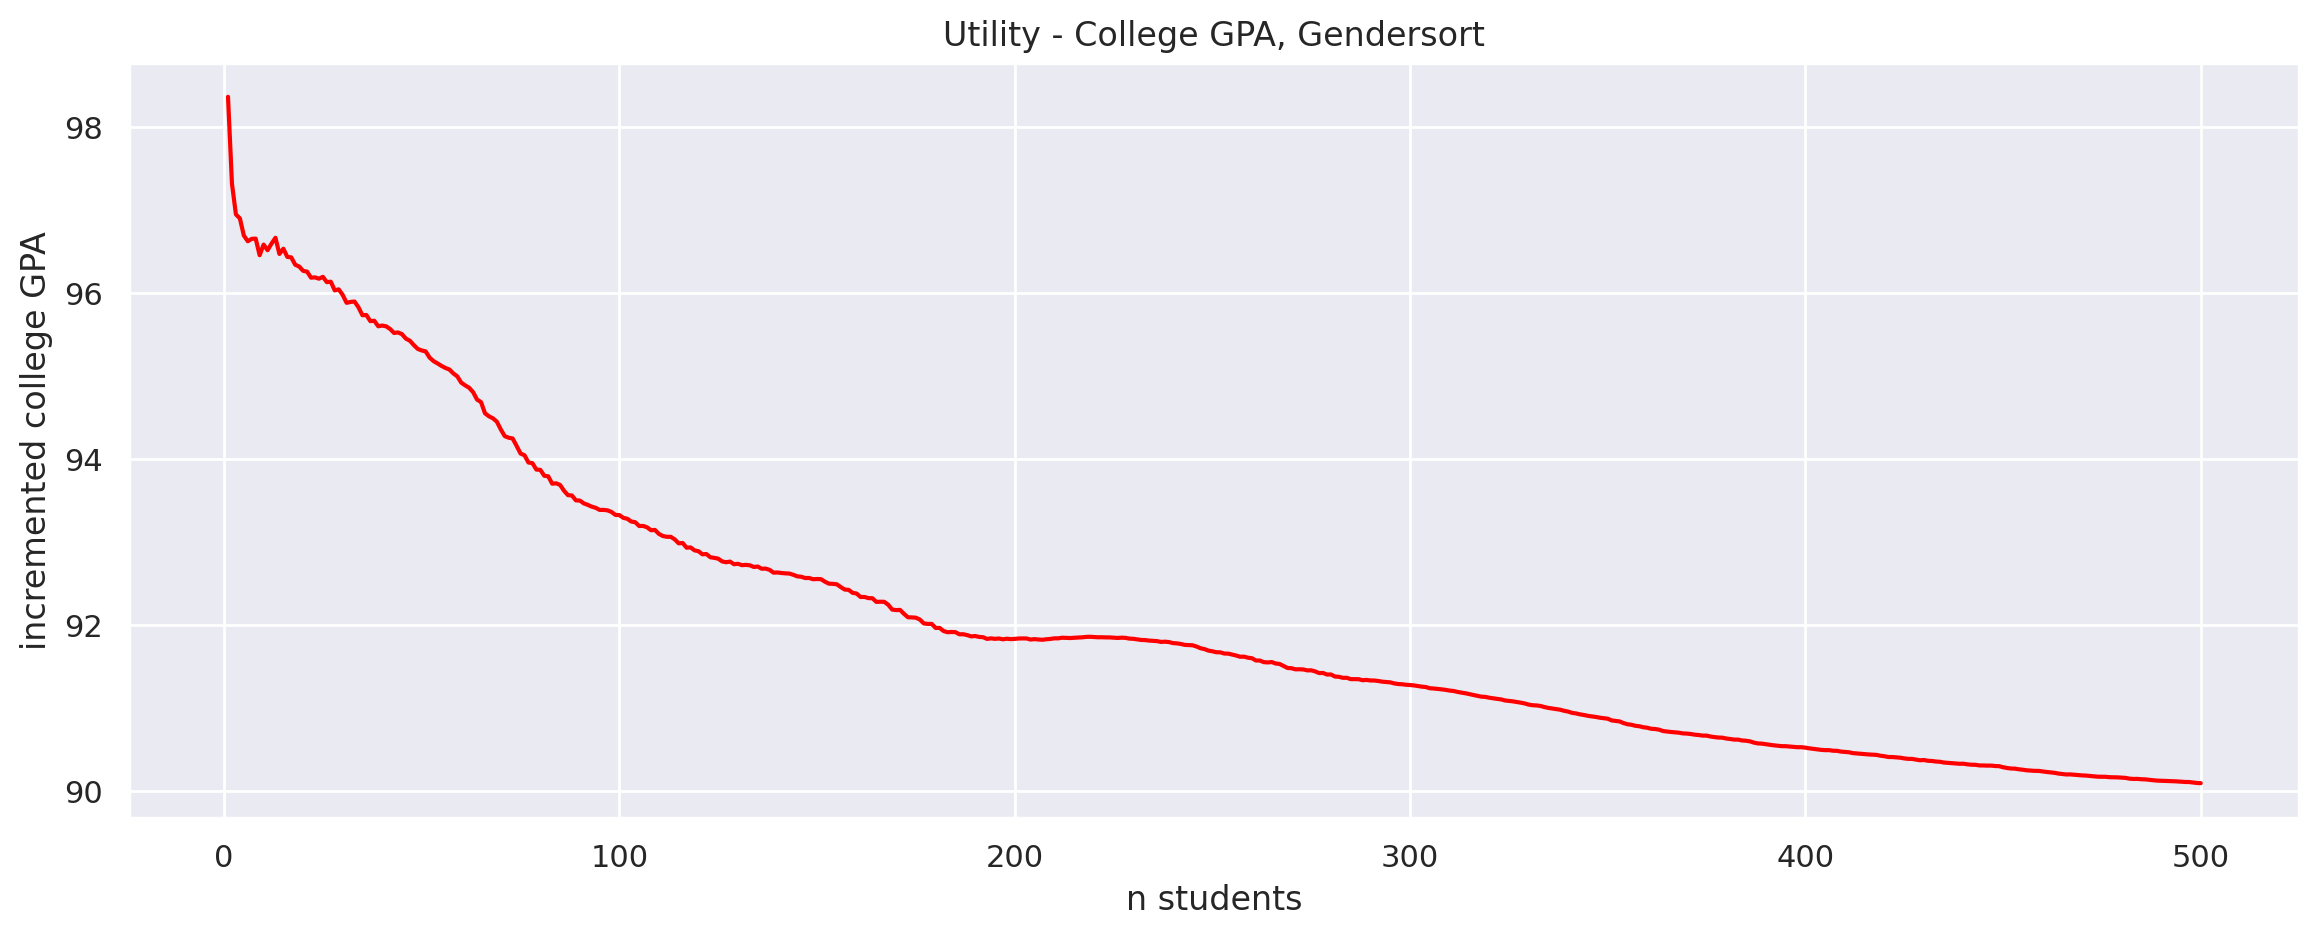

In [91]:
# The gendersort as function of n
#set the incremented col avg as column
gender_df["incr_col_mean"] = gender_df.COL_GRADE_AVG.expanding().mean()
gender_df["n_students"] = range(1,len(gender_df)+1)
# Look of single lineplot of gendersort grades as function of n
# sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color="orange").set_title("Utility - College GPA, Gendersort")
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df_BIG[:500], color="red").set_title("Utility - College GPA, Gendersort")

plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.show()

Forklaringen på, at Plain har lavere utility end without er, at without ikke trækker ned i karakter for kvinder. Without gør muligvis det, at den ikke udnervurderer i toppen. 

# Fairness enhanced Ranker on 200 re-rankings

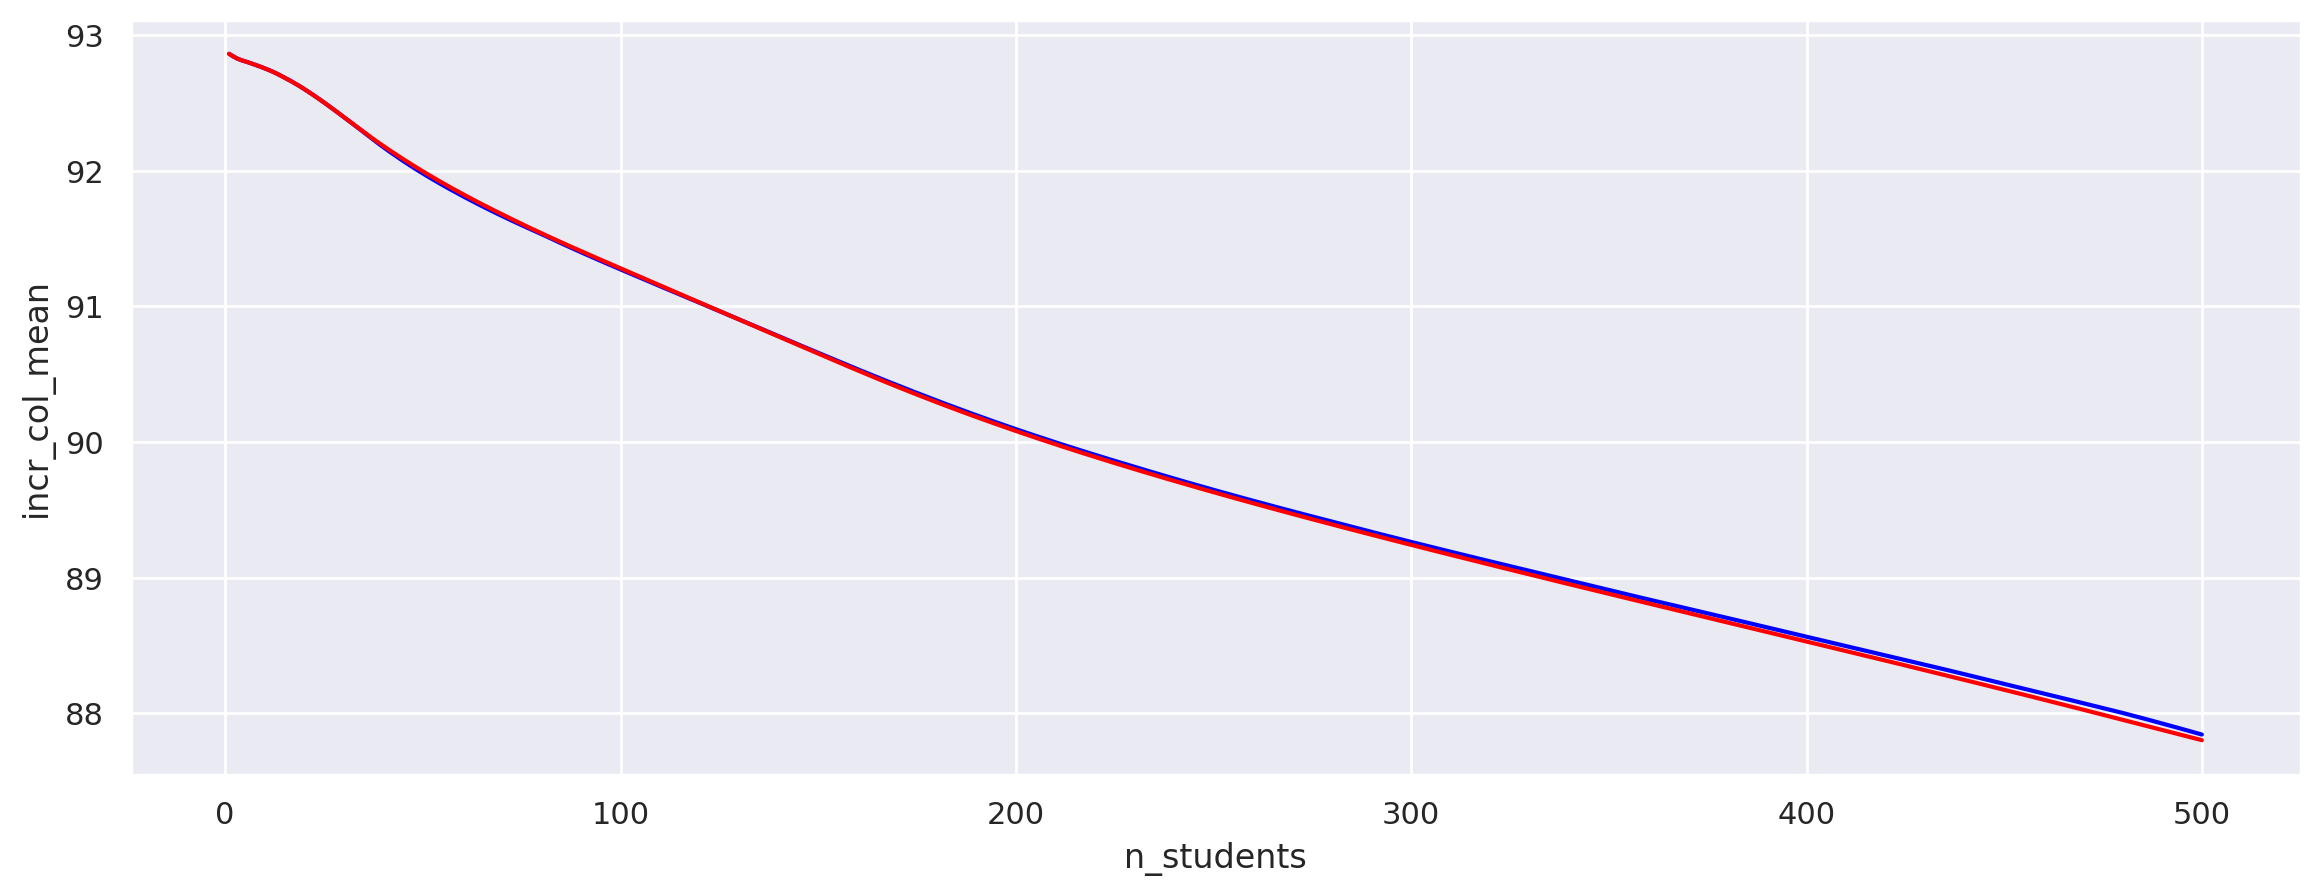

In [ ]:
df_fair_TWO = pd.read_csv('re_ranked_199_NY.csv')
df_fair_TWO_std = df_fair_TWO.groupby('Unnamed: 0').std()
df_fair_TWO_mean=  df_fair_TWO.groupby('Unnamed: 0').mean()
# df_fair_TWO_mean
df_fair_TWO_mean = df_fair_TWO_mean.sort_values(by=['Preds'], ascending=False)
df_fair_TWO_mean["incr_col_mean"] = df_fair_TWO_mean.Preds.expanding().mean()

#cumsum of index to use for plot
df_fair_TWO_mean["n_students"] = range(1,len(df_fair_TWO_mean)+1)
# xgboost 200
Kat_FAIR_utility = sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")
Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="red" , ci="sd")


### Random sort utility
2000 samples of random dataframes are generated and plotted with std. as error bars


In [ ]:
#Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df_for_Mergesort_single.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin"]] #"STRATUM"

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)
#The random df to use

,Unnamed: 0,COL_GRADE_AVG,GENDER_bin,incr_col_mean,n_students
620,5651,80.666667,0,80.666667,1
3931,188,42.000000,0,61.333333,2
718,12189,92.333333,0,71.666667,3
266,10787,48.000000,0,65.750000,4
1591,7034,34.666667,0,59.533333,5
...,...,...,...,...,...
3187,3204,58.000000,0,63.033480,4092
2197,11717,91.000000,1,63.040313,4093
2161,7829,74.666667,0,63.043153,4094
2829,4593,94.333333,0,63.050794,4095


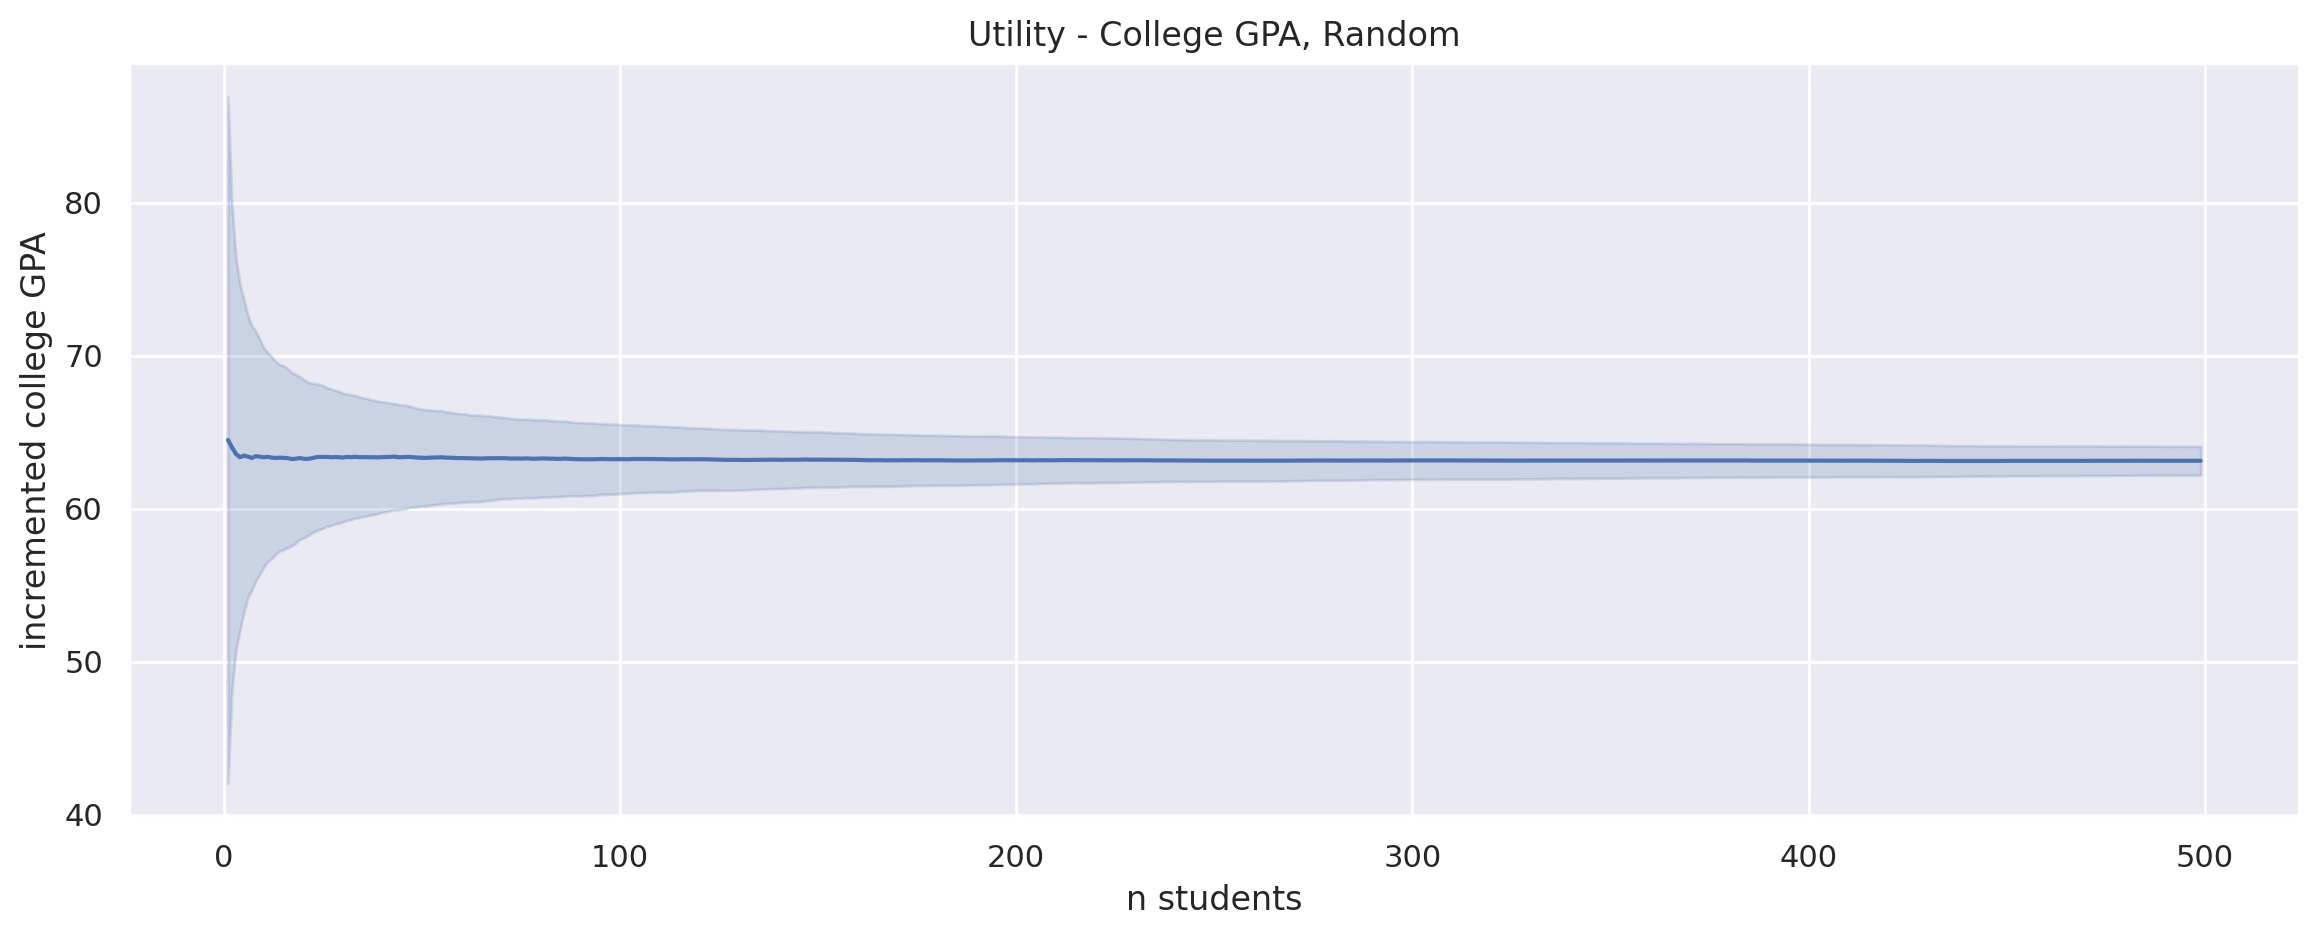

In [ ]:
#only take n students from index 1-500
indexs = np.arange(0,500)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()
#First we plot the random grades per n students
# w 2000 samples
#indexs = np.arange(0,500)
#df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
sns.lineplot(data=df_random_use, x="n_students", y="incr_col_mean", ci="sd")
plt.xlabel('n students')
plt.ylabel('incremented college GPA')
plt.title("Utility - College GPA, Random") 
plt.show()



## Plain XGBoost 

Using "preds" as College scores for XGBoost

Det skal tjekkes her, hvilken af de 3 grafer, der faktisk er den rigtige. 

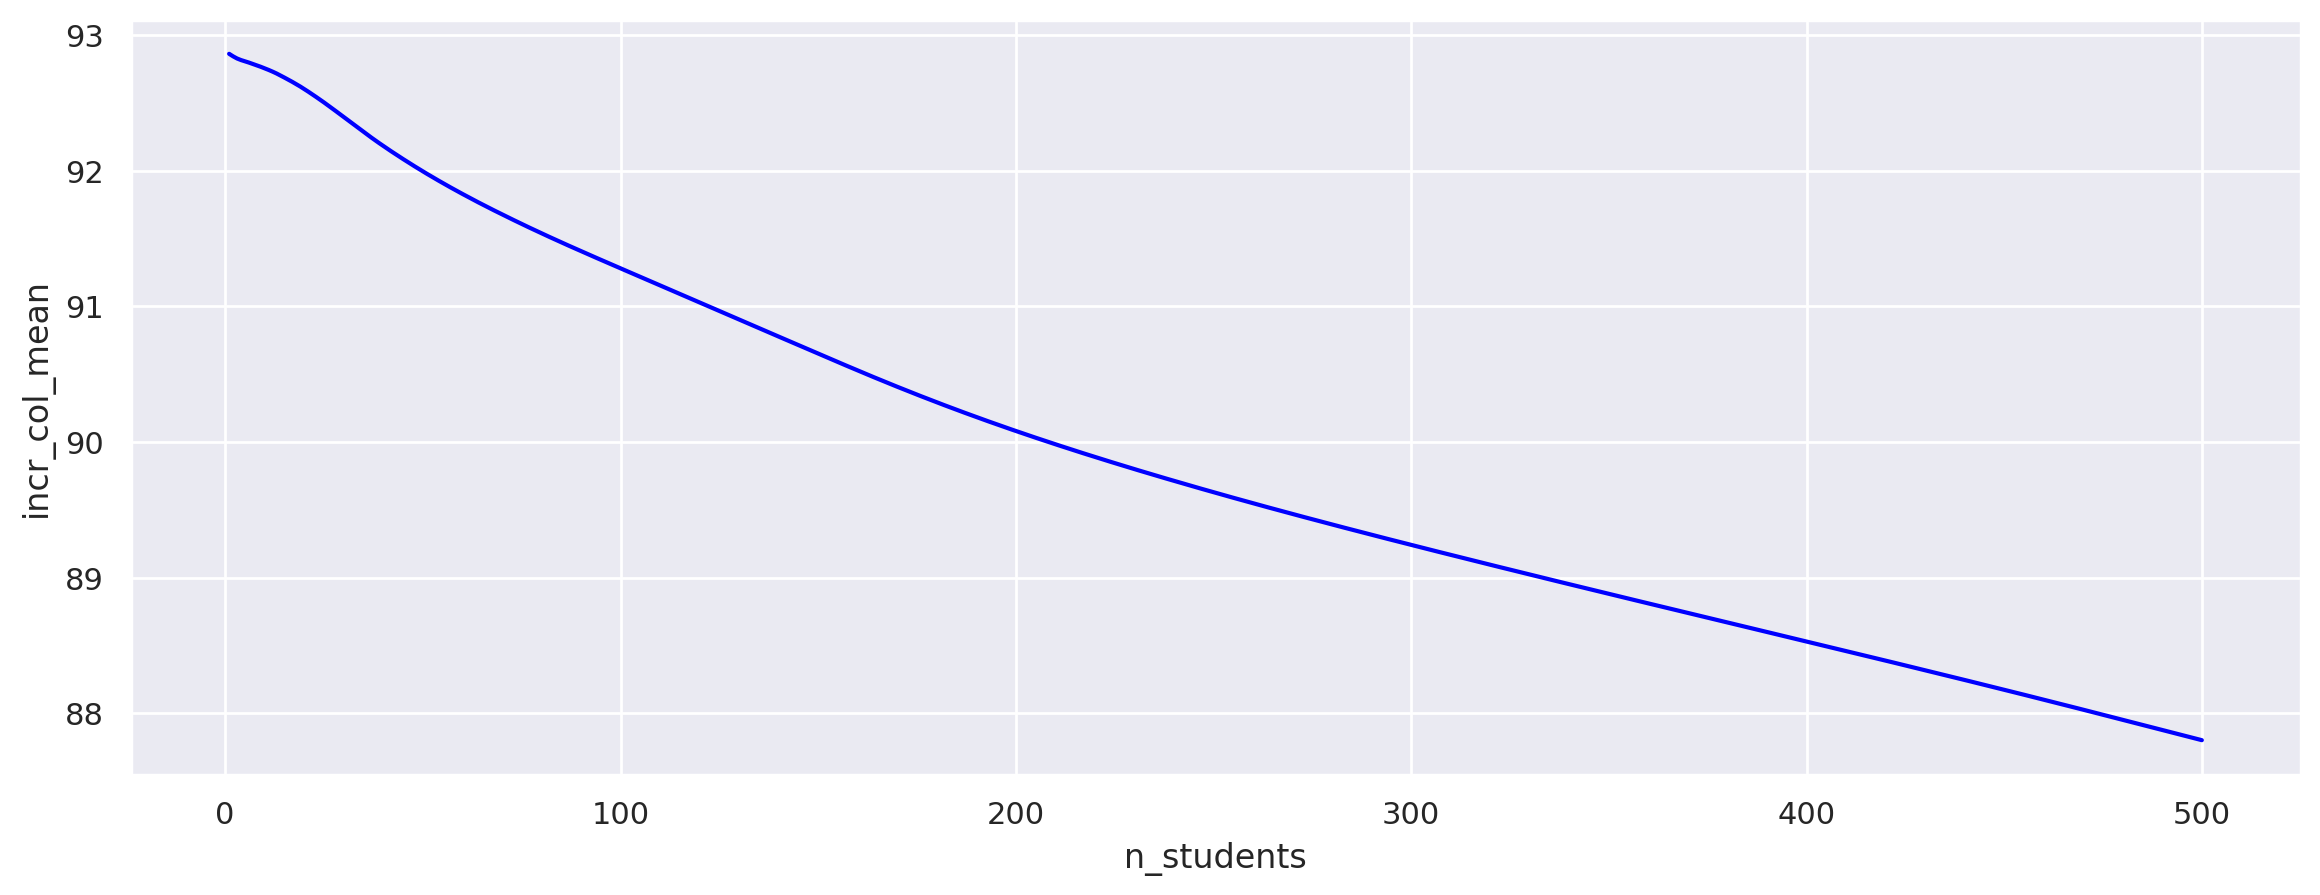

In [43]:
df_plain_TWO = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
df_plain_TWO_std = df_plain_TWO.groupby('Unnamed: 0').std()
df_plain_TWO_mean=  df_plain_TWO.groupby('Unnamed: 0').mean()
df_plain_TWO_mean = df_plain_TWO_mean.sort_values(by=['Preds'], ascending=False)

df_plain_TWO_mean["incr_col_mean"] = df_plain_TWO_mean.Preds.expanding().mean()
df_plain_TWO_mean["n_students"] = range(1,len(df_plain_TWO_mean)+1)

Kat_PLAIN_utility = sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")

## Without sensitive attributes XGBoost

<AxesSubplot:xlabel='n_students', ylabel='incr_col_mean'>

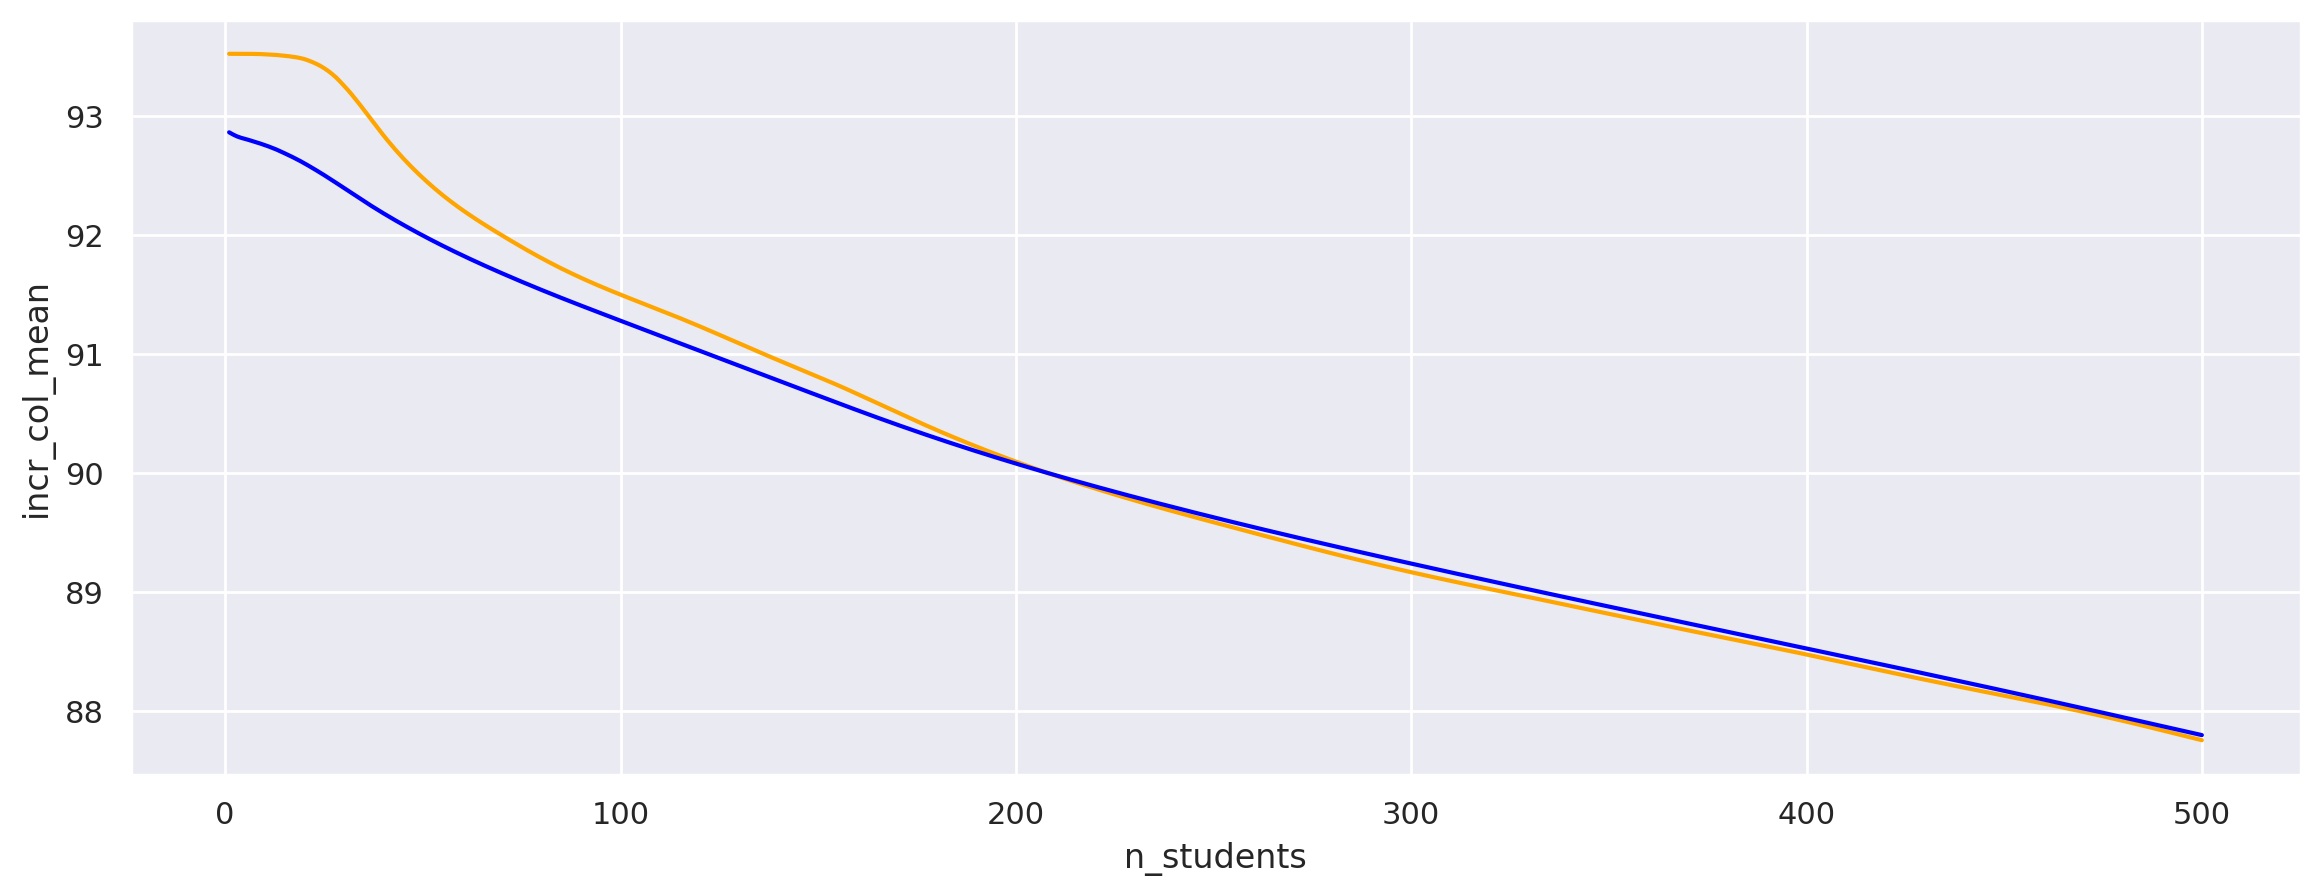

In [44]:
# WO XGBoost
df_wo_TWO = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
df_wo_TWO_std = df_wo_TWO.groupby('Unnamed: 0').std()
df_wo_TWO_mean=  df_wo_TWO.groupby('Unnamed: 0').mean()
df_wo_TWO_mean = df_wo_TWO_mean.sort_values(by=['Preds'], ascending=False)

df_wo_TWO_mean["incr_col_mean"] = df_wo_TWO_mean.Preds.expanding().mean()
df_wo_TWO_mean["n_students"] = range(1,len(df_wo_TWO_mean)+1)

sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="orange" , ci="sd")
sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd")

Forklaringen på, at Plain har lavere utility end without er, at without ikke trækker ned i karakter for kvinder. Without gør muligvis det, at den ikke udnervurderer i toppen. 

# Fairness enhanced Ranker on 200 re-rankings

NameError: name 'df_plain_TWO_mean' is not defined

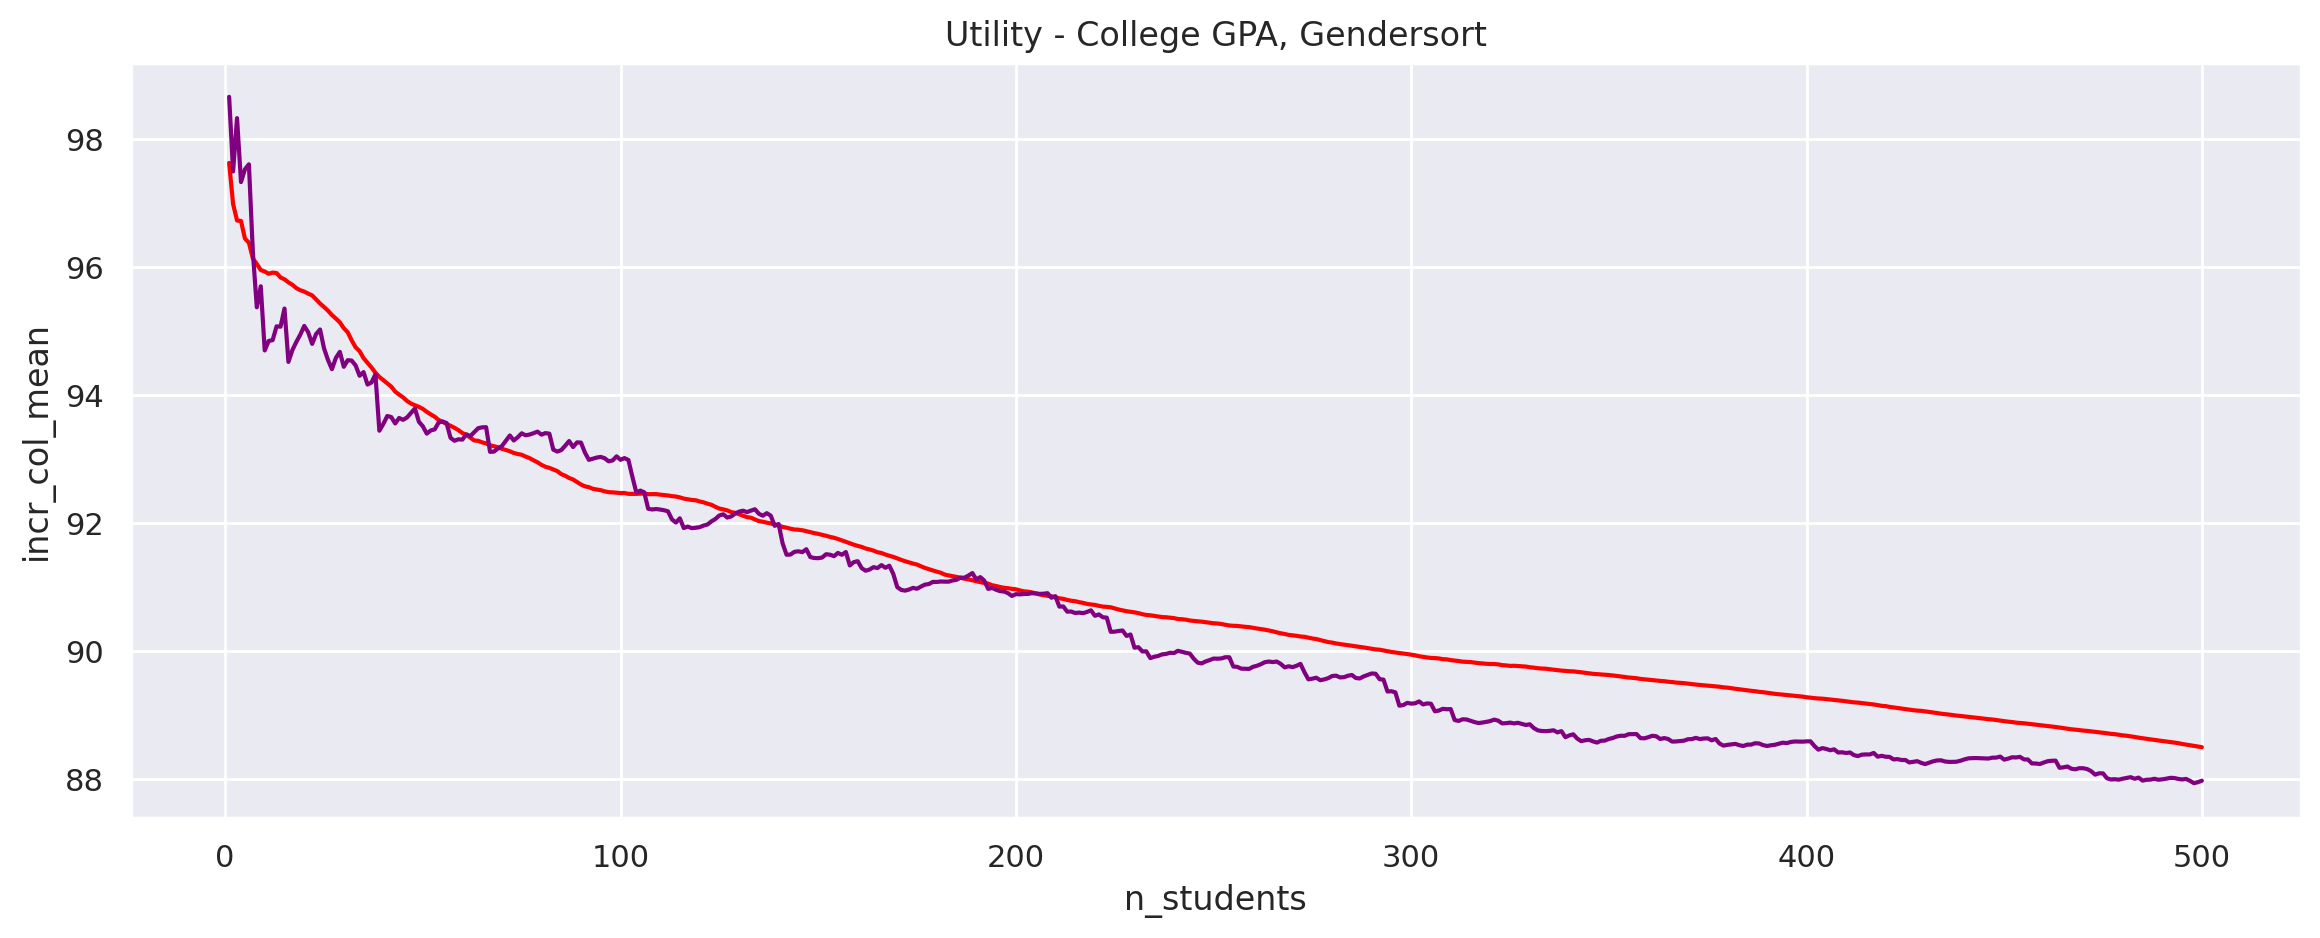

In [80]:
df_fair_TWO = pd.read_csv('re_ranked_199_NY.csv')

df_fair_TWO_std = df_fair_TWO.groupby('Unnamed: 0').std()
df_fair_TWO_mean=  df_fair_TWO.groupby('Unnamed: 0').mean()
# df_fair_TWO_mean
df_fair_TWO_mean = df_fair_TWO_mean.sort_values(by=['Preds'], ascending=False)
df_fair_TWO_mean["incr_col_mean"] = df_fair_TWO_mean.Preds.expanding().mean()

#cumsum of index to use for plot
df_fair_TWO_mean["n_students"] = range(1,len(df_fair_TWO_mean)+1)
# xgboost 200
sns.lineplot(x="n_students", y="incr_col_mean", data=df_sort_BIG[:500], color="red").set_title("Utility - College GPA, Mergesort")
sns.lineplot(x="n_students", y="incr_col_mean", data=gender_df[:500], color="purple").set_title("Utility - College GPA, Gendersort")
sns.lineplot(data=df_plain_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="green" , ci="sd").set_title("Utility - College GPA, Gendersort")
sns.lineplot(data=df_wo_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="orange").set_title("Utility - College GPA, Gendersort")
sns.lineplot(data=df_fair_TWO_mean[:500], x="n_students", y="incr_col_mean",  color="blue" , ci="sd", alpha=0.7).set_title("Utility - College GPA, Gendersort")


plt.xlabel('n students')
plt.ylabel('incremented college GPA')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Utility of models - College GPA, all rankers')
plt.legend(["Mergesort Ranker", "Gendersort Ranker", "Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="upper right")
plt.show()